In [1]:
import tweepy
import json
from pymongo import MongoClient
from collections import Counter
from collections.abc import MutableMapping
import logging
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import community
import seaborn as sns
from fastprogress import master_bar, progress_bar
import time
import re


#Logger
logging.basicConfig(filename='Anàlisi-GetTweetInteractions.log', format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logging.getLogger().addHandler(ch)

In [2]:
##############
# PARAMETERS #
##############

client = MongoClient(username='XXX', password='XXX')

DatabaseName = "Hashtags"
TweetCollectionName = "Campanya-Interactions"
UserCollectionName = "Users"

db = client[DatabaseName]
tweetCollection = db[TweetCollectionName]

In [5]:
###############################################
# GET ACTIVE/PASIVE USER + DROP SIMPLE TWEETS #
###############################################

def load_users(user_collection):
    """Extracts the ObjectID and bot/community tags of users
    
    Keyword arguments:
    user_collection -- MongoDB Users' Collection
    """
    pipeline = [
                {
                    '$project': {
                        '_id': True, 
                        'community': True, 
                        'IS_BOT':True
                    }
                }
            ]
    print("Query", end=" ")
    users = user_collection.aggregate(pipeline, allowDiskUse=True)
    print("OK; List", end=" ")
    users = list(users)
    print("OK; Total users:", len(users))
    return users

tweetCollection = db[TweetCollectionName]

tweets = tweetCollection.find(no_cursor_timeout=True, batch_size=1000000)
users = load_users(db[UserCollectionName])
df_users = pd.DataFrame(users)
df_users = df_users.set_index('_id')

print(df_users)

active_id = 0
passive_id = 0

for result in tweets:
    simple_tweet = False #Initially we consider it false
    active_id = result['user']['id']

    if 'retweeted_status' in result:
        passive_id = result['retweeted_status']['user']['id']
    elif result['is_quote_status']:
        if 'quoted_status' in result:
            passive_id = result['quoted_status']['user']['id']
    elif result['in_reply_to_status_id'] is not None:
        passive_id = result['in_reply_to_user_id']
        #print(result['_id'])
    else:
        simple_tweet = True
    
    if simple_tweet:
        ### DELETE THE TWEET IF IT IS SIMPLE
        try:
            tweetCollection.delete_one({'_id': result['_id']})
        except Exception as e:
            logging.error(e)
            logging.error("Fatal exception deleting document in MongoDB")
    else:
        ### Get Active/Passive community/bot category + update the record
        active_community = df_users.loc[active_id, 'community']
        active_is_bot = df_users.loc[active_id, 'IS_BOT']
        
        try:
            passive_community = df_users.loc[passive_id, 'community']
            passive_is_bot = df_users.loc[passive_id, 'IS_BOT']
        except Exception as e:
            logging.error("Passive Reply user not extracted. ERROR!!!")
            passive_community = "ERROR"
            passive_is_bot = "ERROR"

        try:
            tweetCollection.update_one(
                                        {'_id': result['_id']},
                                        {'$set': 
                                            {
                                                'ACTIVE_community': active_community,
                                                'ACTIVE_IS_BOT': active_is_bot,
                                                'PASSIVE_community': passive_community,
                                                'PASSIVE_IS_BOT': passive_is_bot
                                            }
                                        },
                                        upsert=False,
                                      )
        except Exception as e:
            logging.error(e)
            logging.error("Fatal exception inserting users in MongoDB")
            
        
tweets.close() 

Query OK; List OK; Total users: 253716
                           IS_BOT       community
_id                                              
1353285115422584832           BOT            NONE
1269990151                    BOT  JUNTADEM+MEDIA
1314198625623433216       UNKNOWN    MEDIA+ALTRES
161668113                   HUMAN            NONE
346092587                   HUMAN            NONE
...                           ...             ...
1354919162628464641           BOT            NONE
974431032824025088          HUMAN            NONE
129636906            UNDETERMINED              CS
406416847                   HUMAN             CUP
2887077099                    BOT           JXCAT

[253716 rows x 2 columns]


2021-12-08 18:23:43,677 - root - ERROR - Passive Reply user not extracted. ERROR!!!
2021-12-08 18:23:43,677 - root - ERROR - Passive Reply user not extracted. ERROR!!!
2021-12-08 18:23:43,993 - root - ERROR - Passive Reply user not extracted. ERROR!!!
2021-12-08 18:23:43,993 - root - ERROR - Passive Reply user not extracted. ERROR!!!
2021-12-08 18:23:46,627 - root - ERROR - Passive Reply user not extracted. ERROR!!!
2021-12-08 18:23:46,627 - root - ERROR - Passive Reply user not extracted. ERROR!!!
2021-12-08 18:23:54,525 - root - ERROR - Passive Reply user not extracted. ERROR!!!
2021-12-08 18:23:54,525 - root - ERROR - Passive Reply user not extracted. ERROR!!!
2021-12-08 18:23:58,855 - root - ERROR - Passive Reply user not extracted. ERROR!!!
2021-12-08 18:23:58,855 - root - ERROR - Passive Reply user not extracted. ERROR!!!
2021-12-08 18:24:00,014 - root - ERROR - Passive Reply user not extracted. ERROR!!!
2021-12-08 18:24:00,014 - root - ERROR - Passive Reply user not extracted. E

In [5]:
#######################################
# EXTRACT DATA INTERACTIONS HUMAN-BOT #
#######################################

def load_tweets(collection):
    """Extracts the tweet bot interaction information
    
    Keyword arguments:
    collection -- MongoDB Tweets' Collection
    """
    pipeline = [
                {
                    '$project': {
                        'ACTIVE_IS_BOT': True,
                        'PASSIVE_IS_BOT': True
                    }
                }, {
                    '$group': {
                        '_id': {'ACTIVE_IS_BOT':'$ACTIVE_IS_BOT', 'PASSIVE_IS_BOT':'$PASSIVE_IS_BOT'}, 
                        'count': {
                            '$sum': 1
                        }
                    }
                }
            ]
    print("Query", end=" ")
    tweets = collection.aggregate(pipeline, allowDiskUse=True)
    print("OK; List", end=" ")
    tweets = list(tweets)
    print("OK; Total combinations:", len(tweets))
    return tweets

tweets = load_tweets(tweetCollection)
tweets_df = pd.DataFrame(tweets)
tweets_df2 = pd.concat([pd.json_normalize(tweets_df['_id']), tweets_df['count']], axis=1)

totalTweets = tweets_df2['count'].sum()
print("TOTAL TWEETS: " + str(totalTweets))

print(tweets_df2.sort_values('count', ascending=False).to_string(index=False))

tweets_df3 = tweets_df2.groupby(['ACTIVE_IS_BOT', 'PASSIVE_IS_BOT']).agg({'count': 'sum'})
tweets_df4 = tweets_df3.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

print(tweets_df4.sort_values('ACTIVE_IS_BOT'))

Query OK; List OK; Total combinations: 20
TOTAL TWEETS: 1887122
ACTIVE_IS_BOT PASSIVE_IS_BOT  count
        HUMAN          HUMAN 631088
 UNDETERMINED          HUMAN 382475
        HUMAN   UNDETERMINED 317740
 UNDETERMINED   UNDETERMINED 262913
          BOT          HUMAN  78781
          BOT   UNDETERMINED  64977
        HUMAN            BOT  32792
 UNDETERMINED            BOT  29544
      UNKNOWN          HUMAN  18603
      UNKNOWN   UNDETERMINED  17756
          BOT            BOT  13726
 UNDETERMINED        UNKNOWN  13300
        HUMAN        UNKNOWN  10892
          BOT        UNKNOWN   4361
      UNKNOWN        UNKNOWN   3274
      UNKNOWN            BOT   2391
        HUMAN          ERROR   1730
 UNDETERMINED          ERROR    372
      UNKNOWN          ERROR    280
          BOT          ERROR    127
                                  count
ACTIVE_IS_BOT PASSIVE_IS_BOT           
BOT           BOT              8.474304
              ERROR            0.078409
              HUMAN 

In [3]:
##########################################
# EXTRACT DATA INTERACTIONS BY COMMUNITY #
##########################################

def load_tweets(collection):
    """Extracts the tweet community interaction information
    
    Keyword arguments:
    collection -- MongoDB Tweets' Collection
    """
    pipeline = [
                {
                    '$project': {
                        'ACTIVE_community': True,
                        'PASSIVE_community': True
                    }
                }, {
                    '$group': {
                        '_id': {'ACTIVE_community':'$ACTIVE_community', 'PASSIVE_community':'$PASSIVE_community'}, 
                        'count': {
                            '$sum': 1
                        }
                    }
                }
            ]
    print("Query", end=" ")
    tweets = collection.aggregate(pipeline, allowDiskUse=True)
    print("OK; List", end=" ")
    tweets = list(tweets)
    print("OK; Total combinations:", len(tweets))
    return tweets

tweets = load_tweets(tweetCollection)
tweets_df = pd.DataFrame(tweets)
tweets_df2 = pd.concat([pd.json_normalize(tweets_df['_id']), tweets_df['count']], axis=1)

totalTweets = tweets_df2['count'].sum()
print("TOTAL TWEETS: " + str(totalTweets))

print(tweets_df2.sort_values('count', ascending=False).head(20).to_string(index=False))

tweets_df3 = tweets_df2.groupby(['ACTIVE_community', 'PASSIVE_community']).agg({'count': 'sum'})
tweets_df4 = tweets_df3.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

print(tweets_df4.sort_values('ACTIVE_community').to_string())

Query OK; List OK; Total combinations: 151
TOTAL TWEETS: 1887122
ACTIVE_community PASSIVE_community  count
           JXCAT             JXCAT 412664
             VOX               VOX 386151
             PSC               PSC 229464
          COMUNS            COMUNS 128143
             ERC               ERC 120151
             CUP               CUP 101395
            NONE              NONE 100122
              CS                CS  91866
              PP                PP  88989
        JUNTADEM          JUNTADEM  27416
           JXCAT               CUP  18962
             CUP             JXCAT  13241
           JXCAT               ERC  12431
             VOX                PP   8606
           MEDIA             MEDIA   8060
             ERC             JXCAT   7631
             VOX                CS   6495
           JXCAT              NONE   5819
            NONE             JXCAT   5516
              PP               VOX   5472
                                                     

In [6]:
####################################################
# EXTRACT DATA INTERACTIONS HUMAN-BOT BY COMMUNITY #
####################################################

########### DELETE!!!!
DatabaseName = "StreamingHashtags-FINAL"
TweetCollectionName = "Campanya-Interactions"

db = client[DatabaseName]
########### 

def load_tweets(collection):
    """Extracts the tweet bot and community interaction information
    
    Keyword arguments:
    collection -- MongoDB Tweets' Collection
    """
    pipeline = [
                {
                    '$project': {
                        'ACTIVE_IS_BOT': True,
                        'PASSIVE_IS_BOT': True,
                        'ACTIVE_community': True,
                        'PASSIVE_community': True
                    }
                }, {
                    '$group': {
                        '_id': {'ACTIVE_IS_BOT':'$ACTIVE_IS_BOT', 'PASSIVE_IS_BOT':'$PASSIVE_IS_BOT', 
                                'ACTIVE_community':'$ACTIVE_community', 'PASSIVE_community':'$PASSIVE_community'}, 
                        'count': {
                            '$sum': 1
                        }
                    }
                }
            ]
    print("Query", end=" ")
    tweets = collection.aggregate(pipeline, allowDiskUse=True)
    print("OK; List", end=" ")
    tweets = list(tweets)
    print("OK; Total combinations:", len(tweets))
    return tweets

tweets = load_tweets(db[TweetCollectionName])
tweets_df = pd.DataFrame(tweets)
tweets_df2 = pd.concat([pd.json_normalize(tweets_df['_id']), tweets_df['count']], axis=1)

totalTweets = tweets_df2['count'].sum()
print("TOTAL TWEETS: " + str(totalTweets))

print(tweets_df2.sort_values('count', ascending=False).head(100).to_string(index=False))

tweets_df3 = tweets_df2.groupby(['ACTIVE_community', 'PASSIVE_community', 'ACTIVE_IS_BOT', 'PASSIVE_IS_BOT']).agg({'count': 'sum'})
tweets_df4 = tweets_df3.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

#print(tweets_df4.sort_values('ACTIVE_community').to_string())

print(tweets_df4[tweets_df4['count']>1].sort_values('ACTIVE_community').to_string())

Query OK; List OK; Total combinations: 1660
TOTAL TWEETS: 1887122
ACTIVE_IS_BOT PASSIVE_IS_BOT         ACTIVE_community        PASSIVE_community  count
        HUMAN          HUMAN                    JXCAT                    JXCAT 161050
 UNDETERMINED          HUMAN                    JXCAT                    JXCAT 108116
 UNDETERMINED   UNDETERMINED                      VOX                      VOX  79457
        HUMAN          HUMAN                      VOX                      VOX  74836
        HUMAN          HUMAN                      PSC                      PSC  74524
 UNDETERMINED          HUMAN                      VOX                      VOX  71336
        HUMAN   UNDETERMINED                      VOX                      VOX  59749
 UNDETERMINED          HUMAN                      PSC                      PSC  55270
        HUMAN          HUMAN                      CUP                      CUP  52536
        HUMAN          HUMAN                      ERC                     

"\ntweets_df3 = tweets_df2.groupby(['ACTIVE_community', 'PASSIVE_community', 'ACTIVE_IS_BOT', 'PASSIVE_IS_BOT']).agg({'count': 'sum'})\ntweets_df4 = tweets_df3.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))\n\nprint(tweets_df4.sort_values('ACTIVE_community').to_string())\n"

In [17]:
########################
# PREPARE HEATMAP DATA #
########################


COMMUNITIES_LIST = ["VOX", "JXCAT", "CUP", "COMUNS", "PSC", "ERC", "PP", "CS"]

def load_tweets(collection):
    """Extracts the tweet community interaction information
    
    Keyword arguments:
    collection -- MongoDB Tweets' Collection
    """
    pipeline = [
                {
                    '$project': {
                        'ACTIVE_community': True,
                        'PASSIVE_community': True
                    }
                }, {
                    '$group': {
                        '_id': {'ACTIVE_community':'$ACTIVE_community', 'PASSIVE_community':'$PASSIVE_community'}, 
                        'count': {
                            '$sum': 1
                        }
                    }
                }
            ]
    print("Query", end=" ")
    tweets = collection.aggregate(pipeline, allowDiskUse=True)
    print("OK; List", end=" ")
    tweets = list(tweets)
    print("OK; Total combinations:", len(tweets))
    return tweets

tweets = load_tweets(tweetCollection)
tweets_df = pd.DataFrame(tweets)
tweets_df2 = pd.concat([pd.json_normalize(tweets_df['_id']), tweets_df['count']], axis=1)

totalTweets = tweets_df2['count'].sum()
print("TOTAL TWEETS: " + str(totalTweets))

tweets_df3 = tweets_df2[tweets_df2['ACTIVE_community'].isin(COMMUNITIES_LIST)]
tweets_df4 = tweets_df3[tweets_df3['PASSIVE_community'].isin(COMMUNITIES_LIST)]

#print(tweets_df4.sort_values('count', ascending=False).to_string(index=False))

tweets_df5 = tweets_df4.groupby(['ACTIVE_community', 'PASSIVE_community']).agg({'count': 'sum'})
tweets_df_test = tweets_df5.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

print(tweets_df_test.sort_values('ACTIVE_community').to_string())

#THE RESULTS ARE NOT EXACTLY THE SAME... WE HAVE ELIMINATED SOME RECORDS BEFORE GROUPING AND CALCULATING THE %

Query OK; List OK; Total combinations: 151
TOTAL TWEETS: 1887122
                                        count
ACTIVE_community PASSIVE_community           
COMUNS           COMUNS             90.922830
                 CS                  0.148294
                 CUP                 2.197451
                 ERC                 1.162230
                 JXCAT               2.196032
                 PP                  0.214282
                 PSC                 2.859454
                 VOX                 0.299427
CS               VOX                 4.752669
                 PSC                 1.722990
                 JXCAT               0.495641
                 PP                  2.019786
                 CUP                 0.361446
                 CS                 89.985307
                 COMUNS              0.300715
                 ERC                 0.361446
CUP              COMUNS              2.181402
                 CS                  0.225078
               

In [48]:
tweets_df_test = tweets_df_test.reset_index()  
print(tweets_df_test)

    index ACTIVE_community PASSIVE_community      count
0       0           COMUNS            COMUNS  90.922830
1       1           COMUNS                CS   0.148294
2       2           COMUNS               CUP   2.197451
3       3           COMUNS               ERC   1.162230
4       4           COMUNS             JXCAT   2.196032
..    ...              ...               ...        ...
59     59              VOX               ERC   0.108413
60     60              VOX             JXCAT   0.175678
61     61              VOX                PP   2.120457
62     62              VOX               PSC   0.566457
63     63              VOX               VOX  95.144830

[64 rows x 4 columns]


In [45]:
##########################
# PREPARE HEATMAP DATA 2 #
##########################

#print(tweets_df_test.index[0])
#print(tweets_df_test.name)
index_active = COMMUNITIES_LIST
index_passive = COMMUNITIES_LIST

total_index = list(set(index_active+index_passive))

#print(index_active)
#print(index_passive)

total_index_clean = [x for x in total_index if str(x) != 'nan']

final_index = sorted(total_index_clean)

print(final_index)

['COMUNS', 'CS', 'CUP', 'ERC', 'JXCAT', 'PP', 'PSC', 'VOX']


In [46]:
matrix = np.zeros((len(final_index),len(final_index)))

for active in final_index:
    for passive in final_index:
        #print(active)
        #print(passive)
        value = tweets_df_test[(tweets_df_test["ACTIVE_community"]==active) & (tweets_df_test["PASSIVE_community"]==passive)]["count"]
        matrix[final_index.index(active)][final_index.index(passive)] = value

print(matrix)

[[9.09228302e+01 1.48294261e-01 2.19745133e+00 1.16222966e+00
  2.19603224e+00 2.14281660e-01 2.85945394e+00 2.99426690e-01]
 [3.00715055e-01 8.99853071e+01 3.61445783e-01 3.61445783e-01
  4.95641101e-01 2.01978646e+00 1.72298952e+00 4.75266921e+00]
 [2.18140162e+00 2.25078051e-01 8.17985269e+01 3.37697750e+00
  1.06819300e+01 1.80707826e-01 1.12377679e+00 4.31601281e-01]
 [8.70015919e-01 1.70300988e-01 3.31420532e+00 8.89644959e+01
  5.65029062e+00 1.32538595e-01 7.76720595e-01 1.21432009e-01]
 [1.10345772e+00 7.48893229e-02 4.18894201e+00 2.74616275e+00
  9.11626181e+01 8.06330467e-02 5.31736284e-01 1.11560791e-01]
 [3.58440933e-01 2.26410169e+00 3.30327918e-01 3.37356172e-01
  4.96997932e-01 8.93481797e+01 1.37050945e+00 5.49408623e+00]
 [1.93476784e+00 4.66713048e-01 5.63617088e-01 7.47486293e-01
  5.88464278e-01 2.52198976e-01 9.50255926e+01 4.21159867e-01]
 [1.61387290e-01 1.60032130e+00 1.22457226e-01 1.08412836e-01
  1.75678073e-01 2.12045652e+00 5.66457069e-01 9.51448297e+01]]

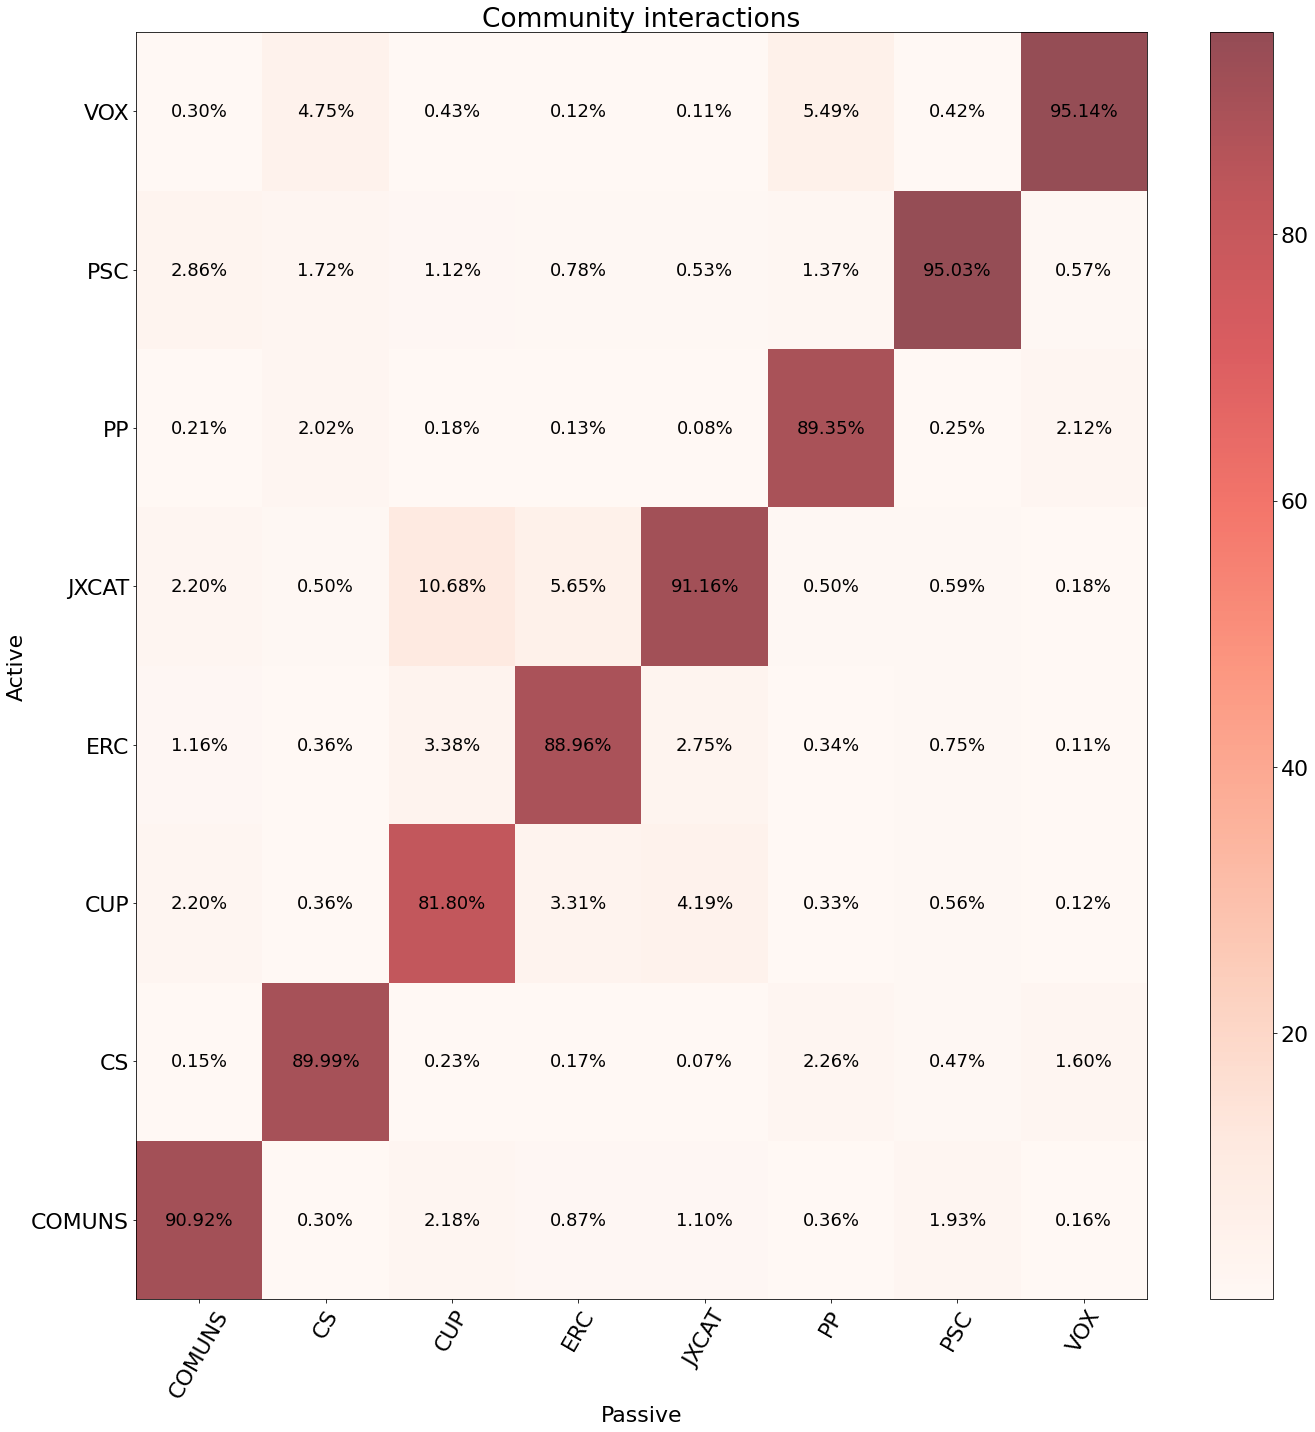

In [68]:
################
# PLOT HEATMAP #
################

def plot_heatmap(m, x_values, y_values, title, xlabel, ylabel, save_fig=False, label_rotation=None):
    """
        Creates a heatmap image from a numpy matrix.

    :param m: 2-dimensional numpy matrix with values to plot
    :param x_values: list of strings for xticks
    :param y_values: list of strings for yticks
    :param title: string, title of the plot
    :param xlabel: string, label of the x axis
    :param ylabel: string, label of the y axis
    :param save_fig: False / "show" / figname , do not show imatge / show it inline / write it to pdf (figure name)
    :param label_rotation: None / int, whether to rotate x ticks (degrees)
    :return:
    """
    
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 1, 1)

    im = ax.imshow(m.transpose(), origin='lower', cmap='Reds', alpha=0.7, aspect='auto')
    #im = ax.imshow(m.transpose(), origin='lower', cmap='jet', alpha=0.7)

    # Colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Loop over data dimensions and create text annotations.
    mt = m.transpose()
    for i in range(len(x_values)):
        for j in range(len(y_values)):
            text = ax.text(j, i, "{:.2f}%".format(mt[i, j]), ha="center", va="center", color="black", alpha=1, fontsize=18)

    # Named ticks
    ax.set_xticks(np.arange(len(x_values)))
    ax.set_yticks(np.arange(len(y_values)))
    ax.set_xticklabels(x_values)
    ax.set_yticklabels(y_values)

    # Axis labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Rotate x labels
    if label_rotation:
        plt.xticks(rotation=label_rotation)

    fig.tight_layout()
    plt.title(title)
    
    plt.rcParams.update({'font.size': 24})

    # Output result
    if not save_fig:
        pass
    elif save_fig == "show":
        plt.show()
    else:
        plt.savefig(save_fig + '.pdf', format='pdf', dpi=600)
        plt.close()

        
######INPUT DATA#####

m = matrix
x_values = final_index
y_values = final_index
title = "Community interactions"
xlabel = "Passive"
ylabel = "Active"
save_fig = "show"

plot_heatmap(m, x_values, y_values, title, xlabel, ylabel, save_fig, 60)